<font color='blue' size=5><b>Комментарий ревьювера</b></font>

<font color='blue'>Рад снова тебя приветствовать, Михаил! Меня зовут Григорий Звездин, и я буду проверять этот проект. Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>

<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>зеленый текст - все отлично</font>

<font color='orange'>оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>красный текст - есть недочеты</font>


---

<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='blue'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

## 1.1 Библиотеки

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

import re
import torch
from transformers import BertTokenizer, BertModel

import nltk
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Хороший набор, надеюсь, все будет реализовано :)

## 1.2 Преднастройки

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\IvanDe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IvanDe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IvanDe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IvanDe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
state = np.random.RandomState(21)

In [ ]:
sns.set()

## 1.3 Стандартные функции

Функция `column_info` показывает информацию по столбцу.

In [ ]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(data[column], ax=ax1)            
            sns.distplot(data[column], kde=False, bins=bins, ax=ax2)            
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Функция `bar_chart` отображает информацию в виде баров в минималистичном виде.

In [ ]:
def bar_chart(array, column_names, title, color='mediumseagreen', figsize=(6,4)):
    plt.figure(figsize=figsize)    
    n = len(array)
    
    bars = plt.bar(np.arange(n), array, color=color)
    
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, height*.90, '{0:.{1}f}'.format(height, 2), 
                     ha='center', color='black', fontsize=11, alpha=0.8)

    plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, labelbottom=True) 
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.xticks(range(n), column_names, alpha=0.8);
    plt.title(title, alpha=0.8)
    plt.tight_layout()

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Отлично!

## 1.4 Исследование

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
df.sample(10, random_state=state)

,text,toxic
45925,Photograph \n\nThere's nothing wrong with your...,0
1242,"""\nre this, it looks like Ultrabias/DY71. ^_^ """,0
105698,No. There is no imagery or significance easil...,0
125591,The title of this article shouldn't have a quo...,0
13235,This IP address has also vandalized Lancaster ...,0
78540,"RE, adding to earlier post by (now out of sync...",0
62924,"""\n\nI didn't find them when I looked for name...",0
23152,"""\nI also note that, contrary to your claim, n...",0
92549,I don't think we should say Yammy's the strong...,0
134736,changing username \n\ni forgot how to change u...,0


In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
column_info(df, 'toxic')


*** Информация по столбцу toxic ***

Тип данных столбца toxic: int64:
В столбце toxic пропущено 0 из 159571 строк, что составляет 0.00%

Количество значений в каждой из категорий:
0    143346
1     16225
Name: toxic, dtype: int64



## 1.5 Подготовка

In [ ]:
def is_balanced(data, column):
    print('Баланс классов: {:.2f}'.format(len(data[data[column]==0]) / len(data[data[column]==1])))

In [ ]:
is_balanced(df, 'toxic')

Баланс классов: 8.83


Разбаланс классов некритический - можно работать с таким.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='orange'>Один класс встречается в 8 раз чаще другого, все-таки не назовешь такой дисбаланс некритическим

def downsample(data, target): 
    data_zeros = data[data[target] == 0] 
    data_ones = data[data[target] == 1]     
 
    data = pd.concat([data_zeros.sample(n=len(data_ones), random_state=state)] + [data_ones])     
    data = shuffle(data, random_state=state)
    return data

Downsample пробовал на обучающей выборке. Результаты получаются только хуже.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='blue'>При таком даунсемплинге сильно уменьшается объем данных, вот и качество хуже. Когда данных мало, лучше пробовать апсемплинг

Выделяем обучающие и целевые признаки.

In [ ]:
X = df['text'].astype('U')
y = df['toxic']

Чистим текст от лишних знаков.

In [ ]:
def text_clear(text):
    text_cleared = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(text_cleared.split())

In [ ]:
X_cleared = X.apply(text_clear)

Подход ниже позволяет провести более тщательную лемматизацию, например, переводить are в be, или лемматизировать слово в зависимости от части речи, что существенно для английского языка. Но вычислительные ресурсы не позволили использовать такой подход. По оценкам процесс занимает более 4 часов.

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def text_lemmatize(text):    
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]           
    return " ".join(lemm_list)

Поэтому была использована более простая лемматизация.

In [ ]:
lemmatizer = WordNetLemmatizer()

def text_lemmatize(text):    
    lemm_list = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)]           
    return " ".join(lemm_list)

Батчи были использованы при попытке лемматизировать 1-м способом.

In [ ]:
batch_size = 100
X_cleared_lemmatized = []
for i in notebook.tqdm(range(X_cleared.shape[0] // batch_size + 1)):
        batch = X_cleared[batch_size*i:batch_size*(i+1)].apply(text_lemmatize)        
        X_cleared_lemmatized.append(batch)

In [ ]:
X_cleared_lemmatized = np.concatenate(X_cleared_lemmatized)

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Отлично, данные очищены и лемматизированы

ВЫделяем обучающую и тестовую выборки в стандартном соотношении 3:1.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cleared_lemmatized, y, random_state=state)

Смотрим, какие по объёму получились выборки.

In [ ]:
X_train.shape

(119678,)

In [ ]:
X_test.shape

(39893,)

# 2. Обучение

Метрику переделывает в скорер.

In [ ]:
f1_scorer = make_scorer(f1_score)

## 2.1Tfidf

Векторизируем признаки методом tfidf.

In [ ]:
count_tfidf = TfidfVectorizer(stop_words=stopwords)

X_train_tfidf = count_tfidf.fit_transform(X_train)
X_test_tfidf = count_tfidf.transform(X_test)

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Верно!

Мало того, что линейные модели быстрее многих прочих, так они ещё покузывают лучший результат по качеству. Для сравнения был взят градиентный бустинг LGBM.

### 2.1.1 Logistic

In [ ]:
%%time

lg = LogisticRegression(max_iter=1000)

parameters = {'C': [.1, .5, 1, 10],
              'class_weight': [None, 'balanced']
              }

lg_grid = GridSearchCV(estimator=lg, param_grid=parameters, cv=3, scoring=f1_scorer)
lg_grid.fit(X_train_tfidf, y_train)

print('Лучший f1 среди всех параметров: {:.2f}'.format(lg_grid.best_score_))
print('Лучшие параметры:', lg_grid.best_params_)

Лучший f1 среди всех параметров: 0.76
Лучшие параметры: {'C': 10, 'class_weight': 'balanced'}
Wall time: 2min 2s


In [ ]:
lg = LogisticRegression(max_iter=1000, C=10, class_weight='balanced').fit(X_train_tfidf, y_train)

lg_f1_tfidf = f1_score(y_test, lg.predict(X_test_tfidf))

print('lg f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train, lg.predict(X_train_tfidf))))
print('lg f1 на тестовой выборке: {:.2f}'.format(lg_f1_tfidf))

lg f1 на обучающей выборке: 0.92
lg f1 на тестовой выборке: 0.76


<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Сразу перепрыгнул необходимый порог, отлично!

### 2.1.2 SVM

In [ ]:
%%time

svc = LinearSVC(max_iter=10000)

parameters = {'C': [.1, .5, 1, 10],
              'class_weight': [None, 'balanced']
              }

svc_grid = GridSearchCV(estimator=svc, param_grid=parameters, cv=3, scoring=f1_scorer).fit(X_train_tfidf, y_train)

print('Лучший f1 среди всех параметров: {:.2f}'.format(svc_grid.best_score_))
print('Лучшие параметры:', svc_grid.best_params_)

Лучший f1 среди всех параметров: 0.76
Лучшие параметры: {'C': 1, 'class_weight': None}
Wall time: 53.5 s


In [ ]:
svc = LinearSVC(max_iter=10000, C=1, class_weight=None).fit(X_train_tfidf, y_train)

svc_f1_tfidf = f1_score(y_test, svc.predict(X_test_tfidf))

print('svc f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train, svc.predict(X_train_tfidf))))
print('svc f1 на тестовой выборке: {:.2f}'.format(svc_f1_tfidf))

svc f1 на обучающей выборке: 0.93
svc f1 на тестовой выборке: 0.78


### 2.1.3 LGBMClassifier

In [ ]:
%%time

lgbm = LGBMClassifier()

parameters = {'learning_rate': [0.1, 1, 10],                           
              'class_weight': [None, 'balanced']
              }

lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=parameters, cv=3, scoring=f1_scorer).fit(X_train_tfidf, y_train)

print('Лучший f1 среди всех параметров: {:.2f}'.format(lgbm_grid.best_score_))
print('Лучшие параметры:', lgbm_grid.best_params_)

Лучший f1 среди всех параметров: 0.74
Лучшие параметры: {'class_weight': None, 'learning_rate': 0.1}
Wall time: 4min 56s


In [ ]:
lgbm = LGBMClassifier(max_depth=15, num_leaves=25, learning_rate=.1).fit(X_train_tfidf, y_train)

lgbm_f1_tfidf = f1_score(y_test, lgbm.predict(X_test_tfidf))

print('lgbm f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train, lgbm.predict(X_train_tfidf))))
print('lgbm f1 на тестовой выборке: {:.2f}'.format(lgbm_f1_tfidf))

lgbm f1 на обучающей выборке: 0.74
lgbm f1 на тестовой выборке: 0.71


## 2.2 Bert

Берт, может быть, и хорош, но не для наших вычислительных ресурсов. Поэтому первоначальная выборака была ограничена объёмом 5000. Что конечно, не совсем корректно для сравнения. Отдельно было проверено, что на одинаковых выбоках Берт показывает лучший результат.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
df = df.sample(n=5000, random_state=state)

features = df['text'].astype('U')
target = df['toxic']

tokenized = features.apply(lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [ ]:
features_bert = np.concatenate(embeddings)

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(features_bert, target, random_state=state)

In [ ]:
X_train_bert.shape

(3750, 768)

In [ ]:
X_test_bert.shape

(1250, 768)

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Круто, что решил не просто попробовать BERT, но и сравнить с TF-IDF! 

### 2.2.1 Logistic

In [ ]:
%%time

lg = LogisticRegression(max_iter=1000)

parameters = {'C': [.1, .5, 1, 10],              
              'class_weight': [None, 'balanced']
              }

lg_grid = GridSearchCV(estimator=lg, param_grid=parameters, cv=3, scoring=f1_scorer)
lg_grid.fit(X_train_bert, y_train_bert)

print('Лучший f1 среди всех параметров: {:.2f}'.format(lg_grid.best_score_))
print('Лучшие параметры:', lg_grid.best_params_)

Лучший f1 среди всех параметров: 0.66
Лучшие параметры: {'C': 0.5, 'class_weight': None}
Wall time: 25.9 s


In [ ]:
lg = LogisticRegression(max_iter=1000, C=.5, class_weight=None).fit(X_train_bert, y_train_bert)

lg_f1_bert = f1_score(y_test_bert, lg.predict(X_test_bert))

print('lg f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train_bert, lg.predict(X_train_bert))))
print('lg f1 на тестовой выборке: {:.2f}'.format(lg_f1_bert))

lg f1 на обучающей выборке: 0.86
lg f1 на тестовой выборке: 0.65


### 2.2.2 SVM

In [ ]:
%%time

svc = LinearSVC(max_iter=10000)

parameters = {'C': [.1, .5, 1, 10],              
              'class_weight': [None, 'balanced']
              }

svc_grid = GridSearchCV(estimator=svc, param_grid=parameters, cv=3, scoring=f1_scorer).fit(X_train_bert, y_train_bert)

print('Лучший f1 среди всех параметров: {:.2f}'.format(svc_grid.best_score_))
print('Лучшие параметры:', svc_grid.best_params_)

Лучший f1 среди всех параметров: 0.62
Лучшие параметры: {'C': 0.1, 'class_weight': None}
Wall time: 1min 10s


In [ ]:
svc = LinearSVC(max_iter=10000, C=0.1, class_weight=None).fit(X_train_bert, y_train_bert)

svc_f1_bert = f1_score(y_test_bert, svc.predict(X_test_bert))

print('svc f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train_bert, svc.predict(X_train_bert))))
print('svc f1 на тестовой выборке: {:.2f}'.format(svc_f1_bert))

svc f1 на обучающей выборке: 0.90
svc f1 на тестовой выборке: 0.62


### 2.2.3 LGBMClassifier

In [ ]:
%%time

lgbm = LGBMClassifier()

parameters = {'learning_rate': [0.1, 1, 10],                            
              'class_weight': [None, 'balanced']
              }

lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=parameters, cv=3, scoring=f1_scorer).fit(X_train_bert, y_train_bert)

print('Лучший f1 среди всех параметров: {:.2f}'.format(lgbm_grid.best_score_))
print('Лучшие параметры:', lgbm_grid.best_params_)

Лучший f1 среди всех параметров: 0.60
Лучшие параметры: {'class_weight': 'balanced', 'learning_rate': 0.1}
Wall time: 44.1 s


In [ ]:
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=15, num_leaves=25, class_weight='balanced').fit(X_train_bert, y_train_bert)

lgbm_f1_bert = f1_score(y_test_bert, lgbm.predict(X_test_bert))

print('lgbm f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train_bert, lgbm.predict(X_train_bert))))
print('lgbm f1 на тестовой выборке: {:.2f}'.format(lgbm_f1_bert))

lgbm f1 на обучающей выборке: 1.00
lgbm f1 на тестовой выборке: 0.63


Проверяем модели на адекватность.

## 2.3 Dummy

In [ ]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(features, target, random_state=state)

dummy = DummyClassifier(strategy="stratified").fit(X_train_dummy, y_train_dummy)

dummy_f1 = f1_score(y_test_dummy, dummy.predict(X_test_dummy))

print('dummy f1 на обучающей выборке: {:.2f}'.format(f1_score(y_train_dummy, dummy.predict(X_train_dummy))))
print('dummy f1 на тестовой выборке: {:.2f}'.format(dummy_f1))

dummy f1 на обучающей выборке: 0.06
dummy f1 на тестовой выборке: 0.09


<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Молодец, что проверяешь модель на адекватность!

# 3. Выводы

In [ ]:
results = pd.DataFrame({'quality': [lg_f1_tfidf, svc_f1_tfidf, lgbm_f1_tfidf, lg_f1_bert, svc_f1_bert, lgbm_f1_bert, dummy_f1]},
                       index=['lg_tfidf', 'svc_tfidf', 'lgbm_tfidf', 'lg_bert', 'svc_bert', 'lgbm_bert', 'dummy']
                       )

In [ ]:
results.sort_values('quality', ascending=False)

,quality
svc_tfidf,0.780373
lg_tfidf,0.760163
lgbm_tfidf,0.710660
lg_bert,0.646288
lgbm_bert,0.626728
svc_bert,0.621277
dummy,0.063636


In [ ]:
results.sort_values('quality', inplace=True, ascending=False)

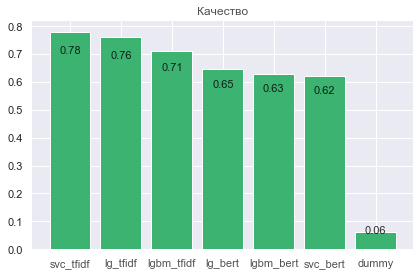

In [ ]:
bar_chart(results.quality, results.index, 'Качество')

Обучение на текстах требует дополнительных вычислительных ресурсов в сравнении с предыдущими задачами, так как большое количество признаков, а это как квадрат влияет на объём вычислений.

Метод tfidf относится более щедяще к компьютерным ресурсам, поэтому он и победил. Bert не позволил провести расчёты на всей выборке. 

Линейные модели проявили себя здесь лучше не только по скорости, но и по качеству.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Да, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, да, и существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.


<b>Полезные (и просто интересные) материалы:</b> \
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP 

<font color='blue'><b>Итоговый комментарий ревьювера</b></font>\
<font color='green'>Михаил, ты сделал отличный проект! Понравилось, что ты не стал ограничиваться чем-то одним, а стал сравнивать классический метод с трансформером\
Надеюсь, тебе будут полезны ссылки, которые я оставил выше</font>


<font color='blue'><b>Проект принят! Успехов :)</b></font>

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны

P.S юпитер жудко глючит.